<a href="https://colab.research.google.com/github/ulfa03/Chili-Leaf-Classification-with-CNN-and-CV/blob/main/CANNY_with_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Image Preprocessing: Load Train, Validation, and Test Data

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path direktori
base_dir = r'C:\Users\PC 06-316\Documents\Dataset PA Daun Cabai'
train_dir = base_dir + r'\train'
val_dir = base_dir + r'\val'
test_dir = base_dir + r'\test'

# Resize ke 224x224
def custom_preprocessing(image):
    image = cv2.resize(image, (48, 48))


    image_uint8 = (image * 255).astype(np.uint8) if image.max() <= 1.0 else image.astype(np.uint8)

    if image_uint8.ndim == 3 and image_uint8.shape[2] == 3:
        gray = cv2.cvtColor(image_uint8, cv2.COLOR_RGB2GRAY)
    else:
        gray = image_uint8
    gray_blurred = cv2.GaussianBlur(gray, (1, 1), 0)

    # Edge detection
    edges = cv2.Canny(gray_blurred, 100, 200)
    edges_color = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)

    # Overlay
    overlay = cv2.addWeighted(image_uint8, 0.8, edges_color, 0.2, 0)

    # Normalisasi
    overlay = overlay.astype(np.float32) / 255.0

    return overlay

# Generator untuk training (dengan augmentasi + preprocessing)
train_datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    preprocessing_function=custom_preprocessing
)

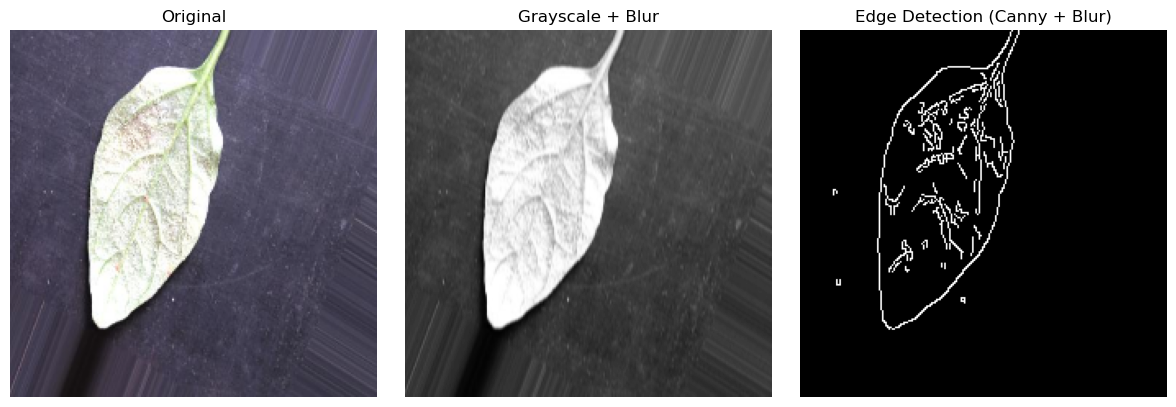

In [ ]:
import cv2
import os
import matplotlib.pyplot as plt

# Path ke gambar spesifik
base_dir = r'C:\Users\PC 06-316\Documents\Dataset PA Daun Cabai'
sample_class = 'Whitefly Leaf'
img_name = 'Whitefly Leaf-09.jpeg'
img_path = os.path.join(base_dir, 'train', sample_class, img_name)

# Load gambar
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img_rgb, (224, 224))

# Grayscale
gray = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)

# Gaussian Blur
gray_blurred = cv2.GaussianBlur(gray, (1, 3), 0)

# Edge detection (Canny) setelah blur
edges = cv2.Canny(gray_blurred, 100, 200)

# Tampilkan hasil
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(img_resized)
plt.title('Original')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(gray_blurred, cmap='gray')
plt.title('Grayscale + Blur')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(edges, cmap='gray')
plt.title('Edge Detection (Canny + Blur)')
plt.axis('off')

plt.tight_layout()
plt.show()


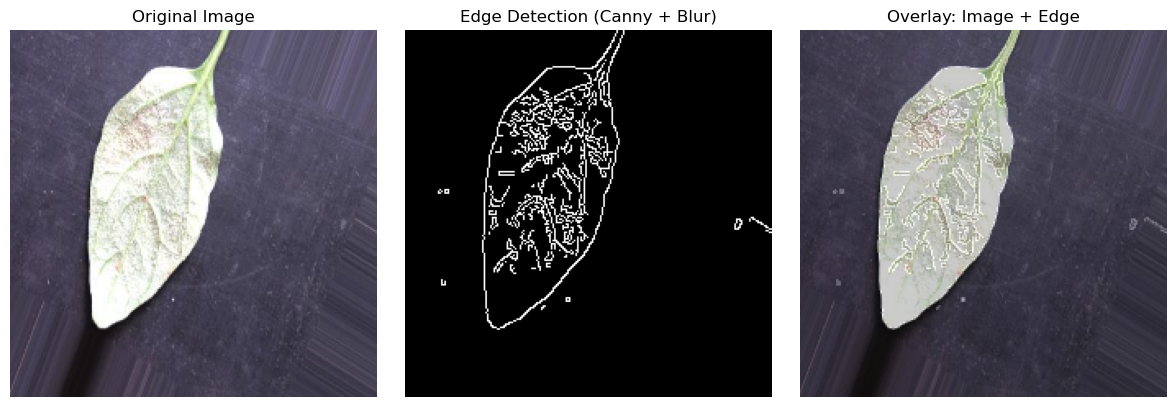

In [ ]:
import cv2
import os
import matplotlib.pyplot as plt

# Path ke gambar spesifik
base_dir = r'C:\Users\PC 06-316\Documents\Dataset PA Daun Cabai'
sample_class = 'Whitefly Leaf'
img_name = 'Whitefly Leaf-09.jpeg'
img_path = os.path.join(base_dir, 'train', sample_class, img_name)

# Load gambar
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img_rgb, (224, 224))

# Grayscale
gray = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)

# Gaussian Blur
gray_blurred = cv2.GaussianBlur(gray, (1, 1), 0)

# Edge Detection (Canny setelah blur)
edges = cv2.Canny(gray_blurred, 100, 200)
edges_rgb = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)

# Overlay
overlay = cv2.addWeighted(img_resized, 0.8, edges_rgb, 0.2, 0)

# Visualisasi
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(img_resized)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(edges, cmap='gray')
plt.title('Edge Detection (Canny + Blur)')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.title('Overlay: Image + Edge')
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
test_val_datagen = ImageDataGenerator(rescale=1./255)

# target size ubah ke 224x224
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

# target size ubah ke 224x224
val_generator = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# target size ubah ke 224x224
test_generator = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(48, 48),  # samakan dengan input model
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 8638 images belonging to 5 classes.
Found 1078 images belonging to 5 classes.
Found 1085 images belonging to 5 classes.


Build Model (VGG-16)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

model = Sequential()
# Convolutional layer pertama
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional layer kedua
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional layer ketiga
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten layer
model.add(Flatten())

# Fully connected layer pertama
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(train_generator.num_classes, activation='softmax'))

# Compile model
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Cek arsitektur model
model.summary()

C:\Users\desktop\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 619,077 (2.36 MB)

 Trainable params: 619,077 (2.36 MB)

 Non-trainable params: 0 (0.00 B)

Training Model

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# ReduceLROnPlateau: mengurangi learning rate saat val_loss stagnan
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# EarlyStopping: hentikan training jika val_loss tidak membaik
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,             # berhenti jika tidak ada perbaikan dalam 5 epoch
    restore_best_weights=True,  # kembali ke model dengan val_loss terbaik
    verbose=1
)

# Gabungkan semua callback
callbacks = [checkpoint, reduce_lr, early_stop]

# Training model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=callbacks
)

C:\Users\desktop\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.3023 - loss: 1.5211

C:\Users\desktop\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 1.06239, saving model to best_model.keras
270/270 ━━━━━━━━━━━━━━━━━━━━ 26s 90ms/step - accuracy: 0.3026 - loss: 1.5206 - val_accuracy: 0.5390 - val_loss: 1.0624 - learning_rate: 1.0000e-04
Epoch 2/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.5632 - loss: 1.0621
Epoch 2: val_loss improved from 1.06239 to 1.00888, saving model to best_model.keras
270/270 ━━━━━━━━━━━━━━━━━━━━ 24s 88ms/step - accuracy: 0.5632 - loss: 1.0621 - val_accuracy: 0.5724 - val_loss: 1.0089 - learning_rate: 1.0000e-04
Epoch 3/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5921 - loss: 0.9876
Epoch 3: val_loss improved from 1.00888 to 0.96044, saving model to best_model.keras
270/270 ━━━━━━━━━━━━━━━━━━━━ 24s 90ms/step - accuracy: 0.5921 - loss: 0.9875 - val_accuracy: 0.5891 - val_loss: 0.9604 - learning_rate: 1.0000e-04
Epoch 4/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.6360 - loss: 0.8807
Epoch 4: val_loss improved from 0.96044 to 0.8

In [ ]:
loss, accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {accuracy:.4f}")

loss, acc = model.evaluate(test_generator)
print(f"Akurasi akhir di data test: {acc:.2f}")

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.7525 - loss: 0.6080
Test accuracy: 0.8046
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.7525 - loss: 0.6080
Akurasi akhir di data test: 0.80


Plot Training History

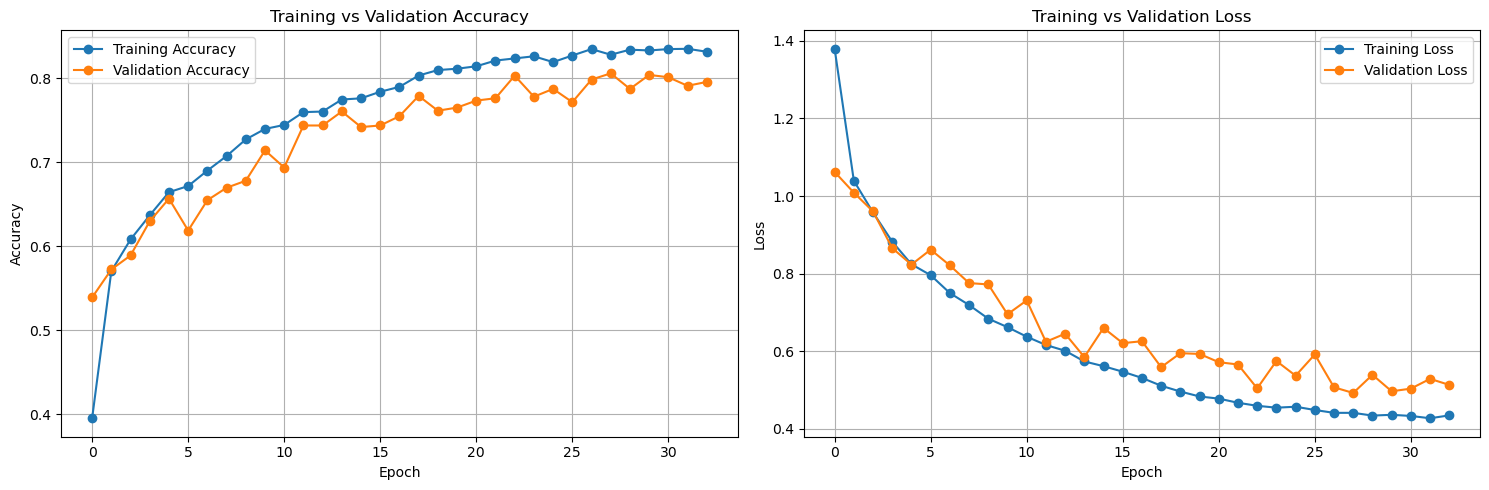

In [ ]:
import matplotlib.pyplot as plt

# Plot akurasi
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Confusion Matrix and Classification Report (Validation)

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step


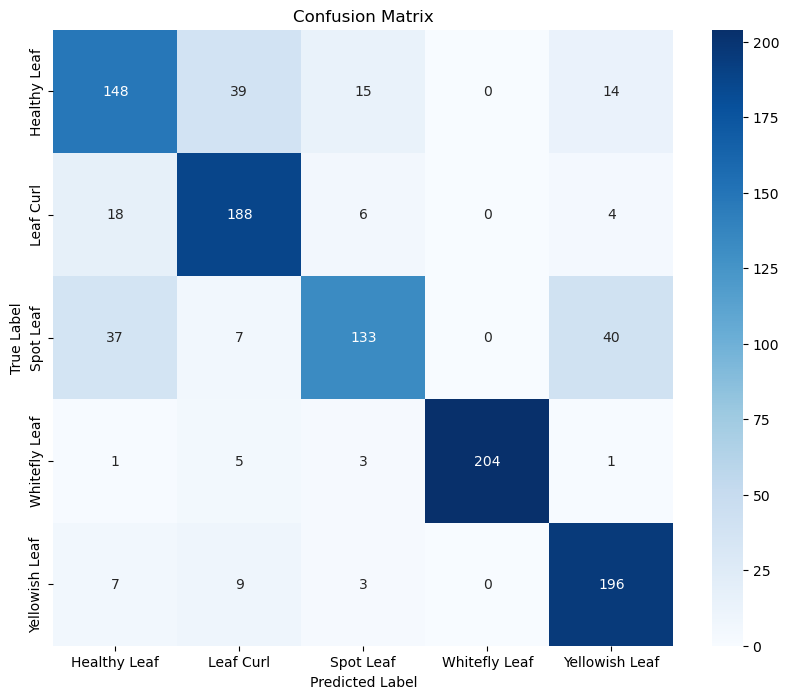


Classification Report:

                precision    recall  f1-score   support

  Healthy Leaf       0.70      0.69      0.69       216
     Leaf Curl       0.76      0.87      0.81       216
     Spot Leaf       0.83      0.61      0.71       217
 Whitefly Leaf       1.00      0.95      0.98       214
Yellowish Leaf       0.77      0.91      0.83       215

      accuracy                           0.81      1078
     macro avg       0.81      0.81      0.80      1078
  weighted avg       0.81      0.81      0.80      1078



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

Y_pred = model.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)


y_true = val_generator.classes


cm = confusion_matrix(y_true, y_pred)

class_names = list(val_generator.class_indices.keys())

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


Confusion Matrix and Classification Report (Testing)

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step


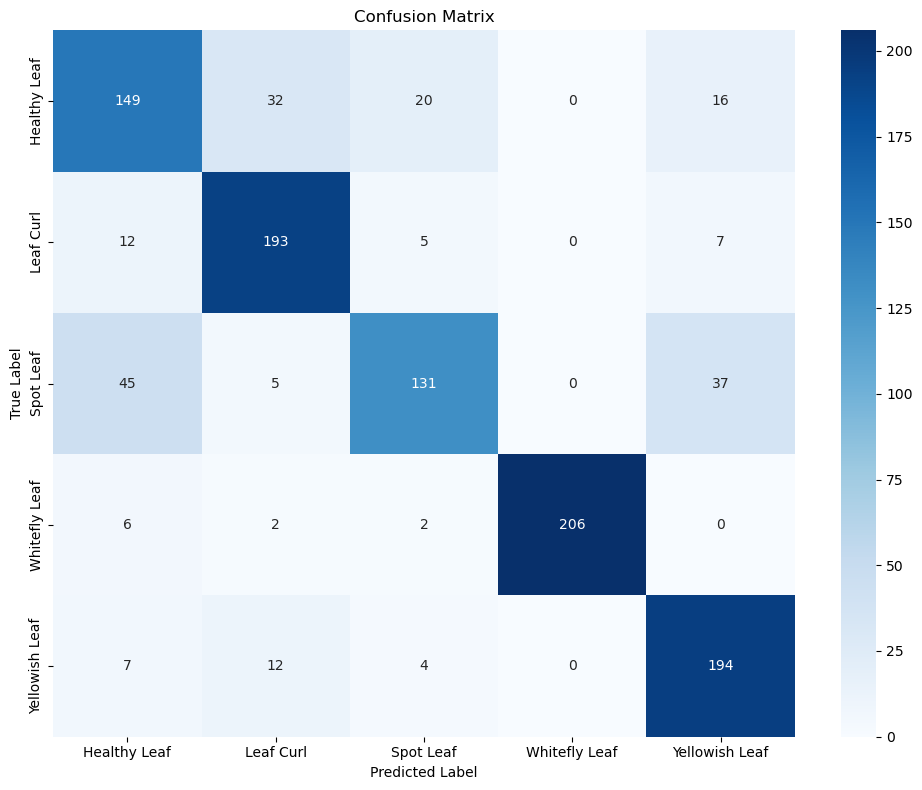


Classification Report:

                precision    recall  f1-score   support

  Healthy Leaf       0.68      0.69      0.68       217
     Leaf Curl       0.79      0.89      0.84       217
     Spot Leaf       0.81      0.60      0.69       218
 Whitefly Leaf       1.00      0.95      0.98       216
Yellowish Leaf       0.76      0.89      0.82       217

      accuracy                           0.80      1085
     macro avg       0.81      0.80      0.80      1085
  weighted avg       0.81      0.80      0.80      1085



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

class_names = list(test_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


Save Model (TFlite)

In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model("best_model.keras")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("modelvgg16.tflite", "wb") as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\desktop\AppData\Local\Temp\tmpcj0kzots\assets


INFO:tensorflow:Assets written to: C:\Users\desktop\AppData\Local\Temp\tmpcj0kzots\assets


Saved artifact at 'C:\Users\desktop\AppData\Local\Temp\tmpcj0kzots'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 48, 48, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  2726185298128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2726185301584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2726185299856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2726185296016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2726185291792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2726185293712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2726185293328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2726185293904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2726185293520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2726185291024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  272618